In [ ]:
!pip install pennylane

In [ ]:
# dependencies

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
# from qlstm_pennylane import QLSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!tar -xf /content/drive/MyDrive/aclImdb_v1.tar.gz

In [ ]:
import torch
import torch.nn as nn

import pennylane as qml


class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size).to(device)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size).to(device)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0].to(device)
            c_t = c_t[0].to(device)

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)


In [ ]:
import torch.nn.functional as F

class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        if n_qubits > 0:
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits).to(device)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentences):
        # def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        lstm_out, _ = self.lstm(embeds.transpose(0, 1))
        lstm_out = lstm_out[-1]  # Take the last output of the LSTM
        tag_logits = self.hidden2tag(lstm_out)
        tag_scores = torch.sigmoid(tag_logits)
        return tag_scores.squeeze()

        # embeds = self.word_embeddings(sentences)
        # lstm_out, _ = self.lstm(embeds.transpose(0, 1))
        # lstm_out = lstm_out.transpose(0, 1)
        # print(lstm_out.shape)
        # tag_logits = self.hidden2tag(lstm_out)
        # print(tag_logits.shape)
        # tag_scores = torch.sigmoid(tag_logits)
        # print(tag_scores.shape)
        # return tag_scores.squeeze()

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import os
import re
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

# Preprocess the text data
def preprocess_text(text):
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Load and preprocess the IMDB dataset
def load_imdb_dataset(data_dir):
    texts = []
    labels = []

    for split in ["train", "test"]:
        for label in ["pos", "neg"]:
            folder = os.path.join(data_dir, split, label)
            files = os.listdir(folder)
            for file in files:
                with open(os.path.join(folder, file), "r", encoding="utf-8") as f:
                    text = f.read()
                    text = preprocess_text(text)
                    texts.append(text)
                    labels.append(1 if label == "pos" else 0)

    return texts, labels
data_dir="/content/aclImdb"
# Split the dataset into training and validation sets
texts, labels = load_imdb_dataset(data_dir)
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create a vocabulary
vocab = {"<PAD>": 0, "<UNK>": 1}
for text in train_texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)
vocab_size=len(vocab)

# Convert text to tensor
def text_to_tensor(text):
    tokens = word_tokenize(text)
    indices = [vocab[token] if token in vocab else vocab["<UNK>"] for token in tokens]
    return torch.tensor(indices)

train_data = [(text_to_tensor(text), label) for text, label in zip(train_texts, train_labels)][0:10]
val_data = [(text_to_tensor(text), label) for text, label in zip(val_texts, val_labels)][0:10]


In [ ]:
train_data = [(text_to_tensor(text), label) for text, label in zip(train_texts, train_labels)][0:20]
val_data = [(text_to_tensor(text), label) for text, label in zip(val_texts, val_labels)][0:20]

In [ ]:
def collate_fn(batch):
    sentences, labels = zip(*batch)
    sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True)
    labels = torch.tensor(labels)
    return sentences, labels


In [ ]:
# Convert the dataset to DataLoader
train_loader = DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False, collate_fn=collate_fn)


In [ ]:
train_data

In [ ]:
vocab_size

192787

In [ ]:
embedding_dim = 8
hidden_dim = 6
n_epochs = 10

In [ ]:
# Create the LSTMTagger model

history_class = {
        'loss': [],
        'acc': []
    }
history_quant = {
    'loss': [],
    'acc': []
}
# Training function
def train(model, data_loader, optimizer, criterion,hist=history_class):
    model.train()
    total_loss = 0.0

    for sentences, labels in tqdm(data_loader, desc="Training"):
        losses = []
        preds = []
        targets = []
        sentences = sentences.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        tag_scores = model(sentences)
        # print(f'tag is {tag_scores},{tag_scores.shape}')

        loss = criterion(tag_scores, labels.float())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    hist['loss'].append(total_loss / len(data_loader))
    return total_loss / len(data_loader)

# Testing function
def test(model, data_loader, criterion, hist):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for sentences, labels in tqdm(data_loader, desc="Testing"):
            sentences = sentences.to(device)
            labels = labels.to(device)

            tag_scores = model(sentences)
            loss = criterion(tag_scores, labels.float().unsqueeze(1))

            total_loss += loss.item()

            # Predict the class based on the sigmoid output
            predicted_classes = torch.round(tag_scores)
            correct += (predicted_classes == labels).sum().item()

    accuracy = correct / len(data_loader.dataset)
    hist['acc'].append(accuracy)
    return total_loss / len(data_loader), accuracy

In [ ]:
# Training loop
model = LSTMTagger(embedding_dim, hidden_dim, vocab_size, 1).to(device)

# Set the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
# epochs = 100
best_val_loss = float("inf")

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    train_loss = train(model, train_loader, optimizer, criterion,history_class)
    val_loss, val_accuracy = test(model, val_loader, criterion, history_class)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}  Val Accuracy: {val_accuracy:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/models/lstm_model.pt")

Tagger will use Classical LSTM
Epoch 1/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Testing:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Testing: 100%|██████████| 20/20 [00:00<00:00, 724.61it/s]


Train Loss: 0.2584
Val Loss: 0.2567  Val Accuracy: 0.3500
Epoch 2/10


Testing: 100%|██████████| 20/20 [00:00<00:00, 738.99it/s]


Train Loss: 0.2539
Val Loss: 0.2571  Val Accuracy: 0.3500
Epoch 3/10


Testing: 100%|██████████| 20/20 [00:00<00:00, 671.74it/s]


Train Loss: 0.2516
Val Loss: 0.2579  Val Accuracy: 0.3500
Epoch 4/10


Testing: 100%|██████████| 20/20 [00:00<00:00, 724.04it/s]


Train Loss: 0.2489
Val Loss: 0.2583  Val Accuracy: 0.4000
Epoch 5/10


Testing: 100%|██████████| 20/20 [00:00<00:00, 705.16it/s]


Train Loss: 0.2470
Val Loss: 0.2596  Val Accuracy: 0.4500
Epoch 6/10


Testing: 100%|██████████| 20/20 [00:00<00:00, 641.46it/s]


Train Loss: 0.2441
Val Loss: 0.2605  Val Accuracy: 0.4000
Epoch 7/10


Testing: 100%|██████████| 20/20 [00:00<00:00, 729.58it/s]


Train Loss: 0.2416
Val Loss: 0.2612  Val Accuracy: 0.4500
Epoch 8/10


Testing: 100%|██████████| 20/20 [00:00<00:00, 688.73it/s]


Train Loss: 0.2394
Val Loss: 0.2623  Val Accuracy: 0.4000
Epoch 9/10


Testing: 100%|██████████| 20/20 [00:00<00:00, 730.91it/s]


Train Loss: 0.2370
Val Loss: 0.2632  Val Accuracy: 0.4000
Epoch 10/10


Testing: 100%|██████████| 20/20 [00:00<00:00, 768.02it/s]

Train Loss: 0.2343
Val Loss: 0.2643  Val Accuracy: 0.4500


In [ ]:
# Load the best model
model.load_state_dict(torch.load("/content/drive/MyDrive/models/lstm_model.pt"))

# Test the model on the test set
test_loss, test_accuracy = test(model, val_loader, criterion, history_class)
print(f"Test Loss: {test_loss:.4f}  Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 20/20 [00:00<00:00, 664.13it/s]

Test Loss: 0.2567  Test Accuracy: 0.3500


In [ ]:
def print_result(model):
    with torch.no_grad():
        input_sentence = val_data[5][0].to(device)
        labels = val_data[5][1]
        if labels==1:
            labels="pos"
        else:
            labels = "neg"
        # inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(input_sentence.unsqueeze(0))
        print(f'tag_scores is:{tag_scores}')
        # tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        if tag_scores>=0.5:
            tag_labels="pos"
        else:
            tag_labels = "neg"
        # print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")
print_result(model)

tag_scores is:0.4915832281112671
Labels:    neg
Predicted: neg


In [ ]:
quant_model = LSTMTagger(embedding_dim, hidden_dim, vocab_size, 1,4).to(device)
# Training loop
# epochs = 100
best_val_loss = float("inf")
criterion = nn.MSELoss()
optimizer = optim.Adam(quant_model.parameters())
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    train_loss = train(quant_model, train_loader, optimizer, criterion, history_quant)
    val_loss, val_accuracy = test(quant_model, val_loader, criterion, history_quant)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}  Val Accuracy: {val_accuracy:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/models/quant_lstm_model.pt")

Tagger will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)
Epoch 1/10


Testing: 100%|██████████| 20/20 [02:31<00:00,  7.58s/it]


Train Loss: 0.2399
Val Loss: 0.2607  Val Accuracy: 0.4000
Epoch 2/10


Testing: 100%|██████████| 20/20 [02:31<00:00,  7.59s/it]


Train Loss: 0.2391
Val Loss: 0.2612  Val Accuracy: 0.4000
Epoch 3/10


Testing: 100%|██████████| 20/20 [02:31<00:00,  7.58s/it]


Train Loss: 0.2385
Val Loss: 0.2618  Val Accuracy: 0.4000
Epoch 4/10


Testing: 100%|██████████| 20/20 [02:30<00:00,  7.54s/it]


Train Loss: 0.2380
Val Loss: 0.2626  Val Accuracy: 0.4000
Epoch 5/10


Testing: 100%|██████████| 20/20 [02:31<00:00,  7.58s/it]


Train Loss: 0.2374
Val Loss: 0.2633  Val Accuracy: 0.4000
Epoch 6/10


Testing: 100%|██████████| 20/20 [02:31<00:00,  7.55s/it]


Train Loss: 0.2368
Val Loss: 0.2639  Val Accuracy: 0.4000
Epoch 7/10


Testing: 100%|██████████| 20/20 [02:31<00:00,  7.58s/it]


Train Loss: 0.2362
Val Loss: 0.2646  Val Accuracy: 0.4000
Epoch 8/10


Testing: 100%|██████████| 20/20 [02:31<00:00,  7.56s/it]


Train Loss: 0.2359
Val Loss: 0.2660  Val Accuracy: 0.4000
Epoch 9/10


Testing: 100%|██████████| 20/20 [02:33<00:00,  7.68s/it]


Train Loss: 0.2349
Val Loss: 0.2668  Val Accuracy: 0.4000
Epoch 10/10


Testing: 100%|██████████| 20/20 [02:31<00:00,  7.56s/it]

Train Loss: 0.2340
Val Loss: 0.2673  Val Accuracy: 0.4000


In [ ]:
# Load the best model
# quant_model.load_state_dict(torch.load("/content/drive/MyDrive/models/quant_lstm_model.pt"))

# Test the model on the test set
test_loss, test_accuracy = test(quant_model, val_loader, criterion, history_quant)
print(f"Test Loss: {test_loss:.4f}  Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 20/20 [02:32<00:00,  7.62s/it]

Test Loss: 0.2673  Test Accuracy: 0.4000


In [ ]:
print_result(quant_model)

tag_scores is:0.4463239014148712
Labels:    neg
Predicted: neg


In [ ]:
from matplotlib import pyplot as plt

def plot_history(history_classical, history_quantum):
    loss_c = history_classical['loss']
    acc_c = history_classical['acc']
    loss_q = history_quantum['loss']
    acc_q = history_quantum['acc']
    n_epochs = max([len(loss_c), len(loss_q)])
    x_epochs = [i for i in range(n_epochs)]

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_c, label="Classical LSTM loss", color='orange', linestyle='dashed')
    ax1.plot(loss_q, label="Quantum LSTM loss", color='red', linestyle='solid')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(acc_c, label="Classical LSTM accuracy", color='steelblue', linestyle='dashed')
    ax2.plot(acc_q, label="Quantum LSTM accuracy", color='blue', linestyle='solid')

    plt.title("IMDB Training")
    plt.ylim(0., 1.1)
    #plt.legend(loc="upper right")
    fig.legend(loc="upper right", bbox_to_anchor=(1,0.8), bbox_transform=ax1.transAxes)

    plt.savefig("pos_training.pdf")
    plt.savefig("pos_training.png")
    plt.show()

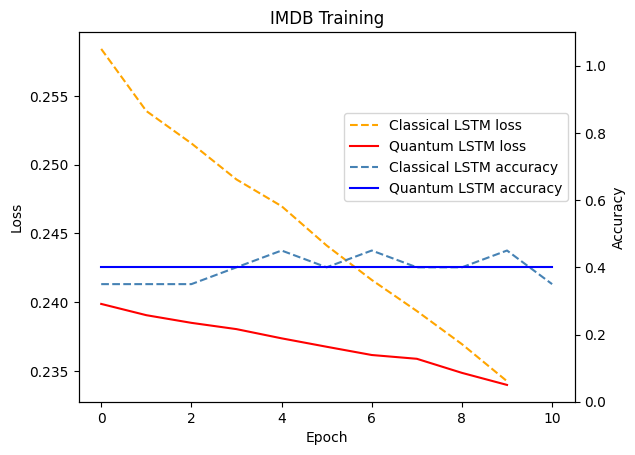

In [ ]:
plot_history(history_class, history_quant)